In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Read the data and save it as a dataframe. Date and Time columns are merged into dt column in datetime format. Values with Nan and ? are treated equally as strings. 
Data Resource: https://www.kaggle.com/uciml/electric-power-consumption-data-set

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dicoding/Belajar Pengembangan Machine Learning/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Fill Nan values with mean of each columns.

In [ ]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

Check if there is anymore Nan values in the dataframe.

In [ ]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Drop all columns, except 'Global_active_power' and dt in order to make univariate data. 

In [ ]:
df = df.drop(columns = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']) 

Save the clean dataframe into a csv file

In [ ]:
df.to_csv(r'/content/drive/My Drive/Dicoding/Belajar Pengembangan Machine Learning/household_power_consumption.csv', index = True)

In [ ]:
df.head()

,Global_active_power
dt,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


Convert the data into numpy array.

In [ ]:
import csv
time_step = []
active_power = []

with open('/content/drive/My Drive/Dicoding/Belajar Pengembangan Machine Learning/household_power_consumption.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  i = 0
  for row in reader:
    active_power.append(float(row[1]))
    time_step.append(i)
    i += 1

series = np.array(active_power)
time = np.array(time_step)

Function to visualize the data

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

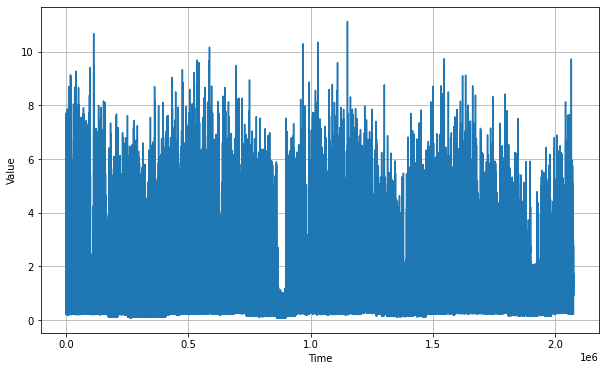

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

I have tried to train the model using all the data (about 2 million rows) and it took a lot of time. Moreover, I experienced too many timeouts when I trained the model. So, now I will reduce the rows to 20000 only, because the minimum data written on the requirement for the submission is 10000. 

In [ ]:
series = series[1900000:1920000]
time = time[1900000:1920000]

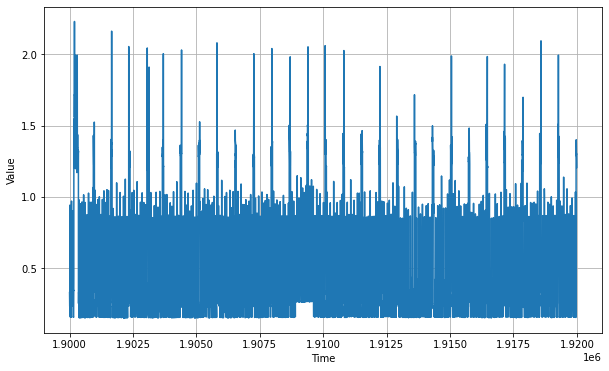

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

Split the rows into train and validation data. (Train = 80%, Validation = 20%)

In [ ]:
split_time = int(0.8*len(time))
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000


Function for converting array into windowed dataset

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

Function for forecasting after we train the model.

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Design the model using LSTM.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

Train the model

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
es = EarlyStopping(monitor='mae', mode='min', patience=2)
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100,callbacks=[es, lr_schedule])

Epoch 1/100
160/160 [==============================] - 5s 33ms/step - loss: 0.3008 - mae: 0.6110
Epoch 2/100
160/160 [==============================] - 5s 33ms/step - loss: 0.2073 - mae: 0.4668
Epoch 3/100
160/160 [==============================] - 5s 34ms/step - loss: 0.1511 - mae: 0.3856
Epoch 4/100
160/160 [==============================] - 5s 34ms/step - loss: 0.1175 - mae: 0.3380
Epoch 5/100
160/160 [==============================] - 5s 34ms/step - loss: 0.0979 - mae: 0.3081
Epoch 6/100
160/160 [==============================] - 6s 35ms/step - loss: 0.0864 - mae: 0.2892
Epoch 7/100
160/160 [==============================] - 5s 34ms/step - loss: 0.0790 - mae: 0.2760
Epoch 8/100
160/160 [==============================] - 6s 35ms/step - loss: 0.0739 - mae: 0.2658
Epoch 9/100
160/160 [==============================] - 6s 36ms/step - loss: 0.0698 - mae: 0.2572
Epoch 10/100
160/160 [==============================] - 5s 34ms/step - loss: 0.0663 - mae: 0.2495
Epoch 11/100
160/160 [=======

Forecasting using validation data.

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

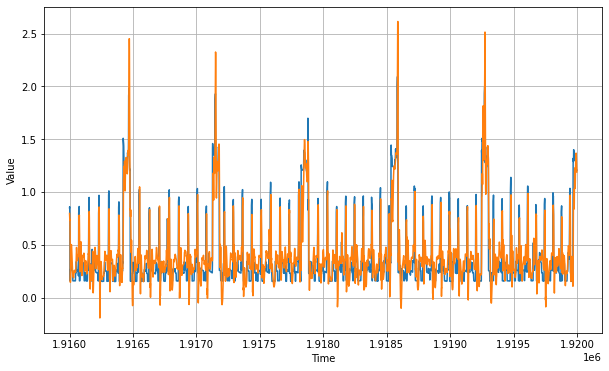

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Calculate the MAE of the validation.

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.13818748

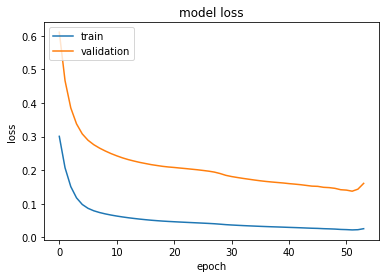

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()